# <center>SEIRD approach in modeling of novel Coronavirus disease 2019 dynamics</center>

<center>
    Ante Lojic Kapetanovic <br>
    <a href="alojic00@fesb.hr">alojic00@fesb.hr</a> <br>
    Faculty of electrical engineering, mechanical engineering and naval architecture <br>
    University of Split <br>
    Split, Croatia
</center>

**Overview** $-$ This report serves as a high-level overview of the compartmental epidemiological deterministic model, more concretely, Susceptible-Exposed-Infected-Recovered-Deceased (SEIRD) model, detail mathematical description is to be found elsewhere (e.g. [Estimation of the Basic Reproduction Number for the Initial Period of the Coronavirus Disease 2019 Epidemic Outbreak in Croatia: Overview](http://adria.fesb.hr/~alojic00/covid-19/covid-19_r0_croatia.html)). Additionaly, uncertainty quantification of the SEIRD output is achieved using Markov chain Monte Carlo (MCMC) method. The goal is to examine how the variability of input epidemiological parameters affects the overall output of the model by treating input epidemiological parameters as random variables and recast the original deterministic model as stochastic model without affecting the configuration of the model itself.

**SEIRD model** $-$ 
\begin{aligned}
\frac{S(t + \Delta t)}{\Delta t} &= -\frac{\beta \cdot S(t) \cdot I(t)}{N} - \langle \delta \rangle \cdot S(t) \cdot E(t) \\
\frac{E(t + \Delta t)}{\Delta t} &= \frac{\beta \cdot S(t) \cdot I(t)}{N} - \langle \alpha \rangle \cdot E(t) + \langle \delta \rangle \cdot S(t) \cdot E(t) \\
\frac{I(t + \Delta t)}{\Delta t} &= \langle \alpha \rangle \cdot E(t) - \langle \gamma \rangle \cdot I(t) - \mu \cdot I(t) \\
\frac{R(t + \Delta t)}{\Delta t} &= \langle \gamma \rangle \cdot I(t) \\
\frac{D(t + \Delta t)}{\Delta t} &= \langle \mu \rangle \cdot I(t) \\ \\
\beta &= 0.5 \\
N &= S(t) + E(t) + I(t) + R(t) + D(t)
\end{aligned}

where $\beta$ is the transition  or  infectious  rate, $\gamma$ is the recovery rate and is determined by the average duration of an infection, $\alpha$ is the incubation rate or the reciprocal value of the incubation period. Since, for  the  case  of  COVID-19  disease,  an  exposed individual is infectious even in the incubation period, $\delta$ represents the direct transition rate between susceptible and exposed compartment. Finally, $\mu$ is the mortality rate.

Each compartment is a function of time, where the sum of all compartments yields to the population number.

Unknown epidemiological input parameters, $\delta$, $\alpha$, $\gamma$ and $\mu$, are all treated as random variables with expected values obtained through inverse system identification using L-BFGS-B optimization of the loss function defined as the difference between *a priori* known confirmed numbers of infectious, recovered and deceased individuals and associated predicted curves obtained via the SEIRD model. The variation coefficient (standard deviation or spread) is defined arbitrarily and is fixed to $0.2$ for the further analysis.

**Keywords** $-$ Coronavirus disease 2019, initial outbreak modeling, exponential function, logistic function, Heidler function, least-squares optimization

**Software** $-$ Ubuntu 18.04 LTS, Python 3.7.6, CoroPy package

In [1]:
import os
import datetime

from coropy.compartmental_models import SEIRDModel
from matplotlib import dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

import plotting

In [2]:
np.random.seed(42)  # for the reproducibility of results

In [3]:
plotting.configure()  # configure paper-quality plots
b = plotting.default_colors('blue')
o = plotting.default_colors('orange')
g = plotting.default_colors('green')
r = plotting.default_colors('red')
p = plotting.default_colors('purple')

In [4]:
# all data
DATA_DIR = 'data'
FILE_NAME = '1st_wave_data_cro.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_recovered = df.estimate_recovered.values
cum_deceased = np.cumsum(df.confirmed_deceased.values)
tests = df.total_tests.values
active = cum_positives - cum_recovered - cum_deceased

In [5]:
# initial conditions
S0 = cum_positives[-1] + cum_deceased[-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
IC = [S0, E0, I0, R0, D0]

# dates
t = np.arange(cum_positives.size)
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(int(t.max())+1)
dates = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))

# transmission rate
beta = 0.5

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

model = SEIRDModel(ode_system=SEIRD_ode)
params, loss = model.fit(cum_positives, cum_recovered, cum_deceased, IC, guess=[0.1, 0.1, 0.1, 0.1])
S, E, I, R, D = model.simulate()

INFO:root:L-BFGS-B optimization started: 2020-10-15 14:34:35.109717
INFO:root:Elapsed time: 23.3666s


In [6]:
# metropolis-hastings

n_iters = 1000
I_sampled = np.zeros(shape=(n_iters, t.size))

for i in range(n_iters):
    noisy_S0 = np.random.normal(loc=S0, scale=0.2*S0)
    noisy_E0 = np.random.normal(loc=E0, scale=0.2*E0)
    noisy_params = np.random.normal(loc=params, scale=0.2*params, size=params.size)
    noisy_sol = solve_ivp(
        SEIRD_ode,
        t_span=(0, int(t[-1])),
        y0=[noisy_S0, noisy_E0, I0, R0, D0],
        args=noisy_params,
        method='RK45',
        t_eval=t,
        vectorized=True,
    )
    if np.mean(noisy_sol.y[2] / I):
        I = noisy_sol.y[2]
    
    I_sampled[i, :] = I  

In [7]:
I_exp = np.mean(I_sampled, axis=0)
I_err = np.std(I_sampled, axis=0)

In [8]:
pcr_sens = 0.9
pcr_spec = 0.97
active_lb_ci, active_lb, active_ub, active_ub_ci = SEIRDModel.calculate_ci(
    pcr_sens,
    pcr_spec,
    df.confirmed_positives.values,
    cum_recovered + cum_deceased,
    tests)

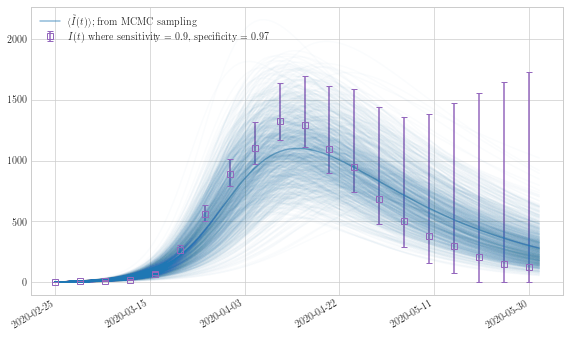

In [9]:
fig = plt.figure()

# active
plt.plot(dates, I_exp, '-', c=b, alpha=0.5, label=r'$\langle \tilde{I}(t) \rangle$; from MCMC sampling')
plt.plot(dates, I_sampled.T, c=b, alpha=0.02)
plt.errorbar(dates, active, 
             yerr=np.r_[
                 (active-active_lb).reshape(1, -1),
                 (active_ub-active).reshape(1, -1)],
             markevery=5,
             errorevery=5, capsize=3,
             marker='s', linestyle='None', mew=1, mfc='none',
             c=p,
             label=f'$I(t)$ where sensitivity = {pcr_sens}, specificity = {pcr_spec}')

plt.legend(loc='upper left')
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()
fname = f'SEIRD_fitted_fixed-beta_first-wave_MC-sampling'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), format='pdf', bbox_inches='tight')